In [1]:
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import os
import math
import h5py
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import pandas as pd
from tqdm import tqdm

import random
import torch
import torch.utils.data
import torch.nn.functional as F
from k_space_reconstruction.utils.metrics import pt_ssim
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt
from k_space_reconstruction.nets.unet import Unet
from collections import defaultdict

torch.manual_seed(228)
random.seed(228)
np.random.seed(228)

env: CUDA_VISIBLE_DEVICES=3


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss

def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

@torch.no_grad()
def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(1 - dice_loss(gt[i][None], pm[i][None]).item())
    return dice_scores

@torch.no_grad()
def test_on_classes_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(dice_coeffs(gt[i][None], pm[i][None]))
    return dice_scores

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path, device=torch.device('cpu')):
        super().__init__()
        self.device = device
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return dict(
            c=c, 
            mask=mask.to(self.device), 
            img=img.to(self.device), 
            mean=mean[None, None, None].to(self.device), 
            std=std[None, None, None].to(self.device)
        )


class DatasetOnDevice(torch.utils.data.Dataset):

    def __init__(self, dataset, device):
        super().__init__()
        self.memory = defaultdict(list)
        for i in tqdm(range(len(dataset)), desc=f'load {dataset} to {device}'):
            data = dataset[i]
            for k in data:
                self.memory[k].append(data[k].to(device) if isinstance(data[k], torch.Tensor) else torch.tensor(data[k]).to(device))
    
    def __len__(self):
        keys = list(self.memory.keys())
        return len(self.memory[keys[0]])

    def __getitem__(self, index):
        return {k:self.memory[k][index] for k in self.memory.keys()}

In [3]:
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = DatasetOnDevice(ACDCDataset('/dev/shm/train.h5'), device)
val_dataset = DatasetOnDevice(ACDCDataset('/dev/shm/val.h5'), device)

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=400, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

load <__main__.ACDCDataset object at 0x7f88816d9910> to cuda:0: 100%|██████████| 1188/1188 [00:05<00:00, 204.80it/s]
load <__main__.ACDCDataset object at 0x7f88b004f070> to cuda:0: 100%|██████████| 514/514 [00:01<00:00, 448.12it/s]


In [4]:
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(
    torch.load('/home/a_razumov/projects/k-space-mri/notebooks/TMI/acdc/unet-acdc-norot.pt', 
    map_location=device)
)

<All keys matched successfully>

In [5]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [8])((256, 256))[0]).to(device).float()
zm = torch.zeros(256).to(device).float()
zm[256//2 - int(32)//2 : 256//2 + int(32)//2] = 1
fm = torch.ones(256).to(device).float()

In [6]:
@torch.no_grad()
def f_func(pattern):
    val = 0
    for data in train_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * pattern).abs()
        simg = (simg - data['mean']) / (data['std'] + 1e-11)
        # val += dice_loss(data['mask'].long(), model(simg))
        val += F.l1_loss(data['img'], simg)
    return val

@torch.no_grad()
def f_grad(pattern, pos):
    _pattern = pattern.clone()
    _pattern[pos] = 1
    val_1 = f_func(_pattern)
    _pattern[pos] = 0
    val_0 = f_func(_pattern)
    return val_1 - val_0

def ba(pattern, estimating, gh, pbar=None):
    g = f_grad(pattern, estimating[0])
    pattern[estimating[0]] = 0 if g > 0 else 1
    gh = torch.eye(pattern.shape[0])[estimating[0]].to(gh.device) * g + gh
    if pbar:
        pbar.set_description(f'{estimating.shape[0]} left')
        pbar.update(1)
    if estimating.shape[0] == 1:
        return pattern, gh
    else:
        return ba(pattern, estimating[1:], gh, pbar)

w = torch.ones(256).float().to(device)
indices = (torch.arange(-w.shape[0]//2, w.shape[0]//2).abs()).argsort()[:128]
pbar = tqdm(range(32), total=32*indices.shape[0])
for _ in pbar:
    w, g = ba(w, indices, torch.zeros_like(w), pbar)
    w[g.argsort()[16:]] = 0

1 left:   1%|          | 32/4096 [06:26<13:37:14, 12.07s/it]


tensor(16., device='cuda:0')


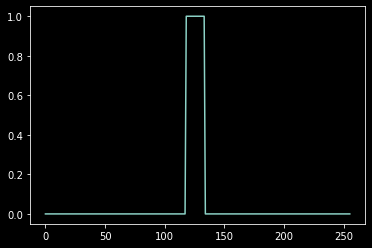

In [7]:
print(w.sum())
plt.plot(w.cpu())
plt.show()

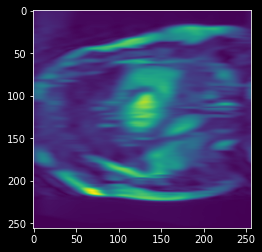

In [8]:
data = train_dataset[0]
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * w).abs()
plt.imshow(simg[0].cpu())

In [9]:
torch.save(w, 'igs.pt')

In [10]:
# torch.save(loupe_w, 'loupe.pt')
# our_w = torch.load('./acdc_igs_masks.pt')[-2]
our_w = torch.load('./igs.pt').to(device)
loupe_w = torch.load('./loupe.pt').to(device)

In [11]:
our_w.norm(p=1), loupe_w.norm(p=1)

(tensor(16., device='cuda:0'), tensor(16., device='cuda:0'))

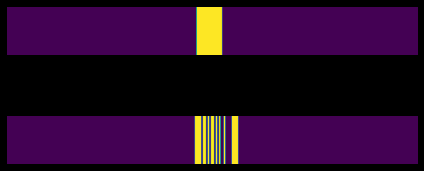

In [19]:
plt.subplot(211)
plt.imshow(our_w.repeat(30,1).cpu())
plt.axis('off')
plt.subplot(212)
plt.imshow(loupe_w.repeat(30,1).cpu())
plt.axis('off')
plt.tight_layout()
plt.show()

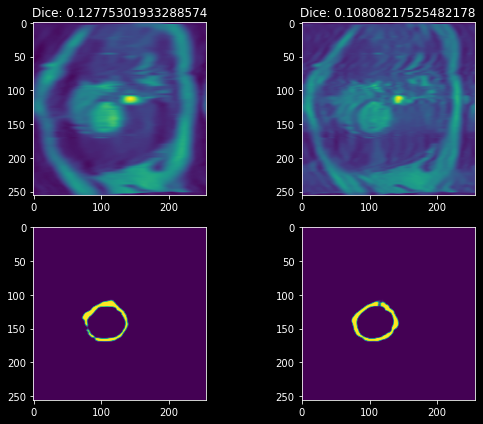

In [20]:
data = val_dataset[0]

plt.figure(figsize=(8,6))
plt.subplot(221)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * our_w).abs()
plt.imshow(simg[0].cpu())
dv = dice_loss(data['mask'][None].long(), model(simg[None])).item()
plt.title(f'Dice: {dv}')
plt.subplot(223)
plt.imshow(model(simg[None]).softmax(1)[0,2].cpu())
plt.subplot(222)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * loupe_w).abs()
plt.imshow(simg[0].cpu())
dv = dice_loss(data['mask'][None].long(), model(simg[None])).item()
plt.title(f'Dice: {dv}')
plt.subplot(224)
plt.imshow(model(simg[None]).softmax(1)[0,2].cpu())
plt.tight_layout()
plt.show()

In [25]:
dice_scores = dict(
    fastmri=test_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_sampling_pattern(zm, model, val_generator),
    loupe=test_sampling_pattern(loupe_w, model, val_generator),
    ours=test_sampling_pattern(our_w, model, val_generator),
    full=test_sampling_pattern(fm, model, val_generator),
)

df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,fastmri,center,loupe,ours,full
count,514.000000,514.000000,514.000000,514.000000,514.000000
mean,0.005063,0.005099,0.006412,0.005737,0.006735
std,0.003234,0.003567,0.004208,0.003835,0.004097
min,0.001240,0.001050,0.001442,0.001189,0.001598
25%,0.002180,0.001922,0.002611,0.002255,0.002302
50%,0.004445,0.004492,0.005386,0.004842,0.006266
75%,0.007040,0.007235,0.008976,0.008062,0.009714
max,0.016593,0.016063,0.018794,0.017399,0.019309
